<a href="https://colab.research.google.com/github/xanderdavies/toy_model_grokking/blob/main/toy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Model for Grokking and Double Descent

Xander Davies, Lauro Langosco, and David Krueger

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

We model the learning of *patterns*, or particular input-output function learned during the training process. Pattern $i$ has predictiveness $\text{pred}_i(t)$ at timestep $t$ (i.e., portion of training set they know), parameterized by a maximum predictiveness $\gamma_i$, inflection point $b_i$, and learning speed $\alpha_i$:
\begin{equation}
\text{pred}_i(t) = \frac{\gamma_i}{1 + e^{-\alpha_i(x - b_i)}}
\end{equation}

Features then generalize according to:
\begin{equation}
\text{gen}_i(t) = g_i \cdot \text{pred}_i(t)
\end{equation}

We model double descent & grokking learning dynamics through three patterns (or groups of patterns with equivalent properties):
1. *Fast-to-learn, well-generalizing patterns (heuristics).* In double descent, we model these patterns as being able to explain 70% of the data ($\gamma_1 = .7$) and generalizing perfectly ($g_1=1$). In grokking, we say there aren't any such heuristics ($\gamma_1=0$). 
2. *Medium-to-learn, poorly-generalizing patterns (overfitting).* This category of pattern includes memorization, so has $\gamma_2 = 1$ and $g_2=0$ in both double descent and grokking.
3. *Slow-to-learn, well-generalizing patterns, which are __favored__.* In both cases, we say $g_3=1$, but in double descent we say these patterns can only explain 20% of the data ($\gamma_1 = .2$) and in grokking we say it can explain all of the data ($\gamma_1 = 1$). These patterns (in both cases) have the special property of being *preferred*, which means they are used in any case where they are predictive (as opposed to this being decided randomely in cases where multiple patterns overlap).

We define accuracy $\text{acc}(t)$ at timestep $t$ per:

\begin{align}
\text{acc}(t) &= \text{pred}_1(t) \cup \text{pred}_2(t) \cup \text{pred}_3(t) \\
&= \text{pred}_1(t) + \text{pred}_2(t) + \text{pred}_3(t) - \left(\text{pred}_1(t) \text{pred}_2(t) + \text{pred}_1(t) \text{pred}_3(t) + \text{pred}_2(t) \text{pred}_3(t)\right) + \text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) 
\end{align}

We define pattern usage $u_i(t)$ as the proportion of examples seen by $p_i$ at timestep $t$, which is upperbounded by $\text{pred}_i(t)$:
\begin{align}
u_1(t) &= \text{pred}_1(t) - \text{pred}_1(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_2(t) &= \text{pred}_2(t) - \text{pred}_2(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_3(t) &= \text{pred}_3(t)
\end{align}

*Note that $u_1(t) + u_2(t) + u_3(t) \leq 1$, $\forall t \geq 0, \text{pred}_i \leq 1$.*

We then say our model generalizes according to each pattern's generality $g_i$ applied to each usage $u_i(t)$:

\begin{align}
\text{gen}(t) = g_1 u_1(t) + g_2 u_2(t) + g_3 u_3(t)
\end{align}

In [4]:
def pred_i(p, t):
  return p["gamma"] / (1 + np.exp(-p["alpha"]*(t - p["b"])))

def acc(p_1, p_2, p_3, t):
  preds = [pred_i(p_1, t), pred_i(p_2, t), pred_i(p_3, t)]
  return preds[0] + preds[1] + preds[2] - preds[0]*preds[1] - preds[0] * preds[2] - preds[1] * preds[2] + preds[0] * preds[1] * preds[2]

def gen(p_1, p_2, p_3, t):
  preds = [pred_i(p_1, t), pred_i(p_2, t), pred_i(p_3, t)]
  u_1 = preds[0] - preds[2]*preds[0] - preds[0]*preds[1]/2 + preds[0]*preds[1]*preds[2]/2
  u_2 = preds[1] - preds[2]*preds[1] - preds[0]*preds[1]/2 + preds[0]*preds[1]*preds[2]/2
  u_3 = preds[2]
  return u_1*p_1["g"] + u_2*p_2["g"] + u_3*p_3["g"]

In [5]:
#@title Double Descent <> Grokking

#@markdown *To transition between double descent and grokking, lower the predictiveness of heuristics, and increase the predictiviness of the slow well-generalizing patterns.*

import ipywidgets as widgets
grokking = False
STEPS = 300

p_1 = {
    "gamma": 0. if grokking else 0.7,
    "alpha": .15,
    "b": 30,
    "g": 1,
}

p_2 = {
    "gamma": 1,
    "alpha": .15,
    "b": 50,
    "g": 0,
}

p_3 = {
    "gamma": 1. if grokking else 0.2,
    "alpha": .05,
    "b": 200,
    "g": 1,
}

@widgets.interact(heuristics=(0., 1.), slow_good=(0., 1.))
def plot_grok_dd(heuristics=p_1["gamma"], slow_good=p_3["gamma"]):
  p_1["gamma"] = heuristics
  p_3["gamma"] = slow_good

  x = np.arange(0, STEPS)
  fig, axs = plt.subplots(1, 2, figsize=(20,8))
  fig.canvas.header_visible = False

  # feature learning
  heuristics, = axs[0].plot(x, pred_i(p_1, x), label="heuristics")
  memorization, = axs[0].plot(x, pred_i(p_2, x), label="overfitting")
  slow, = axs[0].plot(x, pred_i(p_3, x), label="slow \nwell-generalizing")
  axs[0].set_xlabel("epochs")
  axs[0].set_ylabel("Predictiveness")
  axs[0].legend()
  axs[0].set_title("Pattern Learning")

  # accuracy
  train, = axs[1].plot(x, acc(p_1, p_2, p_3, x), label="train", color="gray")
  test, = axs[1].plot(x, gen(p_1, p_2, p_3, x), label="test", color="red")
  axs[1].set_xlabel("epochs")
  axs[1].set_ylabel("Accuracy")
  axs[1].set_title("Accuracy")
  axs[1].legend()

interactive(children=(FloatSlider(value=0.7, description='heuristics', max=1.0), FloatSlider(value=0.2, descri…

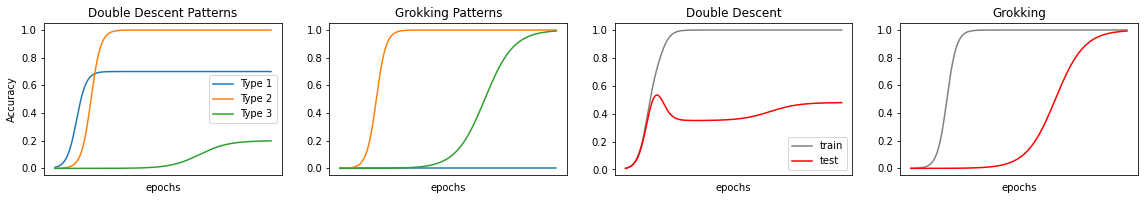

In [3]:
#@title Figure in paper

STEPS = 300

p_1 = {
    "gamma": 0.7,
    "alpha": .15,
    "b": 30,
    "g": 1,
}

p_2 = {
    "gamma": 1,
    "alpha": .15,
    "b": 50,
    "g": 0,
}

p_3 = {
    "gamma": 0.2,
    "alpha": .05,
    "b": 200,
    "g": 1,
}

x = np.arange(0, STEPS)
fig, axs = plt.subplots(1, 4, figsize=(28*.7,4*.7))

## Double Descent
# feature learning
heuristics, = axs[0].plot(x, pred_i(p_1, x), label="Type 1")
memorization, = axs[0].plot(x, pred_i(p_2, x), label="Type 2")
slow, = axs[0].plot(x, pred_i(p_3, x), label="Type 3")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].set_xticks([])
axs[0].set_title("Double Descent Patterns")

# accuracy
train, = axs[2].plot(x, acc(p_1, p_2, p_3, x), label="train", color="gray")
test, = axs[2].plot(x, gen(p_1, p_2, p_3, x), label="test", color="red")
# axs[2].set_ylabel("Accuracy")
axs[2].set_xlabel("epochs")
axs[2].set_xticks([])
axs[2].set_title("Double Descent")
axs[2].legend()

## GROK
p_1["gamma"] = 0.
p_3["gamma"] = 1.# feature learning
heuristics, = axs[1].plot(x, pred_i(p_1, x), label="Type 1")
memorization, = axs[1].plot(x, pred_i(p_2, x), label="Type 2")
slow, = axs[1].plot(x, pred_i(p_3, x), label="Type 3")
# axs[1].set_ylabel("Predictiveness")
# axs[1].legend(loc="lower left")
axs[1].set_xlabel("epochs")
axs[1].set_xticks([])
axs[1].set_title("Grokking Patterns")

# accuracy
train, = axs[3].plot(x, acc(p_1, p_2, p_3, x), label="train", color="gray")
test, = axs[3].plot(x, gen(p_1, p_2, p_3, x), label="test", color="red")
# axs[3].set_ylabel("Accuracy")
axs[3].set_xlabel("epochs")
axs[3].set_xticks([])
axs[3].set_title("Grokking")
# axs[3].legend(loc="lower right");

plt.savefig("toy_model.pdf")